In [1]:
import pandas as pd
import numpy as np
import joblib
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os

In [2]:
# STEP 1: Load Soil Dataset
# df = pd.read_csv("Crop_recommendation.csv")
# Get the absolute path to the 'data' directory

# STEP 1: Load Soil Dataset from data/ folder
# BASE_DIR = model/ folder (in Jupyter it is usually where notebook is)
BASE_DIR = os.getcwd()
# DATA_DIR is one level up (AgriGuru/) + /data
DATA_DIR = os.path.join(os.path.dirname(BASE_DIR), "data")
# Now load the CSV
df = pd.read_csv(os.path.join(DATA_DIR, "Crop_recommendation.csv"))

In [3]:
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


In [5]:
df.describe()

,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


In [6]:
df.isnull().sum()

N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64

In [7]:
df["label"].value_counts()

label
rice           100
maize          100
chickpea       100
kidneybeans    100
pigeonpeas     100
mothbeans      100
mungbean       100
blackgram      100
lentil         100
pomegranate    100
banana         100
mango          100
grapes         100
watermelon     100
muskmelon      100
apple          100
orange         100
papaya         100
coconut        100
cotton         100
jute           100
coffee         100
Name: count, dtype: int64

In [8]:
df["label"].value_counts().count()

np.int64(22)

In [9]:
# STEP 2: Split into Train_Test_Split
X = df[["N", "P", "K", "ph", "temperature", "humidity", "rainfall"]]
y = df["label"]

X_train, X_test, y_train_raw, y_test_raw = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# STEP 3: Encode Labels
le = LabelEncoder()
y_train = le.fit_transform(y_train_raw)
y_test = le.transform(y_test_raw)

# Save the encoder
joblib.dump(le, "label_encoder.pkl")

['label_encoder.pkl']

In [11]:
# STEP 4: Model selection
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

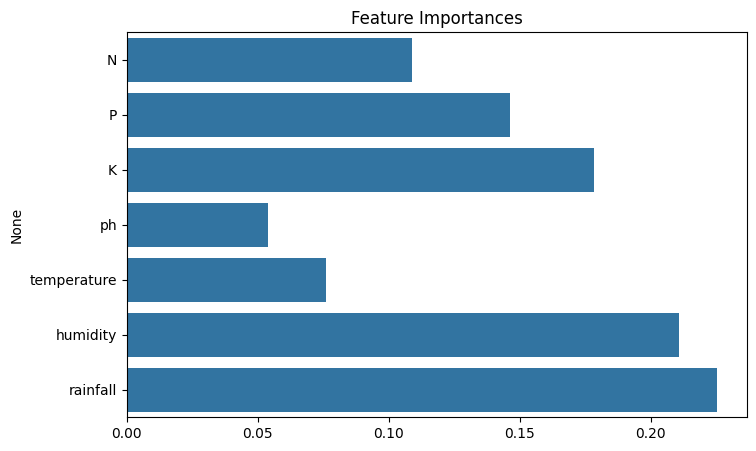

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot feature importances
plt.figure(figsize=(8, 5))
sns.barplot(x=model.feature_importances_, y=X.columns)
plt.title("Feature Importances")
plt.show()

In [13]:
# STEP 5: Evaluate
y_pred = model.predict(X_test)
print("✅ Model Accuracy:", accuracy_score(y_test, y_pred))

✅ Model Accuracy: 0.9931818181818182


In [14]:
# Print confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

[[23  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 21  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 26  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 27  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 23  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 21  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0 23  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0

In [15]:
# STEP 6: Save Model
joblib.dump(model, "crop_model.pkl")

['crop_model.pkl']